In [115]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
#tf.enable_eager_execution()
#AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.14.0


In [0]:
#os.environ['KAGGLE_USERNAME'] = 'trinidadrae'
#os.environ['KAGGLE_KEY'] = "752461eac767321609bc8ca2e3a62d82"

In [116]:
#Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
filepath = '/content/drive/My Drive/Siraj_ML/week_4/chest-xray-pneumonia/chest_xray'
# filepath = '/content/drive/My Drive/Siraj_ML/week_4/chest-xray-pneumonia/chest_xray'
train_dir =  filepath + '/train'
validation_dir = filepath + '/val'
test_dir = filepath + '/test'

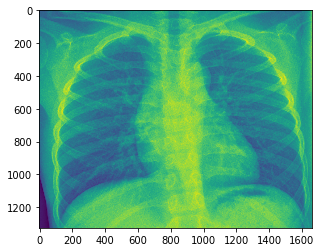

In [118]:
#Test If the file are uploaded by displaying a random Xray
import matplotlib.image as mpimg
img = test_dir + '/NORMAL/IM-0006-0001.jpeg'
img = mpimg.imread(img) 
imgplot = plt.imshow(img)
plt.show()

**Image Preprocessing/ Augmentation**

In [119]:
# this is the augmentation configuration we will use for training:
from keras.preprocessing.image import ImageDataGenerator, load_img

rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])
  
validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(test_dir),
    shuffle = False)

Found 5227 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Estimate class weights for unbalanced datasets.**

In [120]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current
class_weight = get_weight(train_generator.classes)
class_weight

array([1.94023756, 0.67358247])

**Designing Sequential Model**

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

# switching Keras between TensorFlow and Theano backends
from keras import backend as K
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    

def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

In [0]:
model = get_conv_model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 37, 37, 64)       

**Check information about model**

In [0]:
model.input

<tf.Tensor 'conv2d_47_input:0' shape=(?, 150, 150, 3) dtype=float32>

In [0]:
model.output

<tf.Tensor 'dense_14/Softmax:0' shape=(?, 2) dtype=float32>

**Build Model**:Compile It

In [0]:
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']


model.compile(optimizer, loss=loss, metrics=metrics)


**Build Model**:Train It

In [0]:
nb_train_samples = 5217
nb_validation_samples = 17
epochs = 10
batch_size = 16
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight=class_weight)


Epoch 1/10
326/326 [==============================] - 935s 3s/step - loss: 0.3632 - acc: 0.8399 - val_loss: 0.9394 - val_acc: 0.6875
Epoch 2/10
326/326 [==============================] - 934s 3s/step - loss: 0.1291 - acc: 0.9530 - val_loss: 1.1032 - val_acc: 0.6250
Epoch 3/10
326/326 [==============================] - 928s 3s/step - loss: 0.0952 - acc: 0.9657 - val_loss: 1.2374 - val_acc: 0.6250
Epoch 4/10
326/326 [==============================] - 934s 3s/step - loss: 0.0914 - acc: 0.9678 - val_loss: 0.4891 - val_acc: 0.6875
Epoch 5/10
326/326 [==============================] - 946s 3s/step - loss: 0.0760 - acc: 0.9715 - val_loss: 0.1597 - val_acc: 0.9375
Epoch 6/10
326/326 [==============================] - 886s 3s/step - loss: 0.0692 - acc: 0.9739 - val_loss: 0.6378 - val_acc: 0.7500
Epoch 7/10
326/326 [==============================] - 865s 3s/step - loss: 0.0941 - acc: 0.9644 - val_loss: 0.1280 - val_acc: 0.9375
Epoch 8/10
326/326 [==============================] - 925s 3s/step - 

**Evaluate The Model**

In [88]:
# valid_loss, valid_accuracy = model.evaluate_generator(validation_generator)
# print("Model Accuracy: {}".format(valid_accuracy))

Model Accuracy: 0.875


In [124]:
test_loss, test_score = model.evaluate_generator(test_generator)
print("Model Accuracy: {}".format(test_score))

Model Accuracy: 0.9246794581413269


In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)


ValueError: ignored

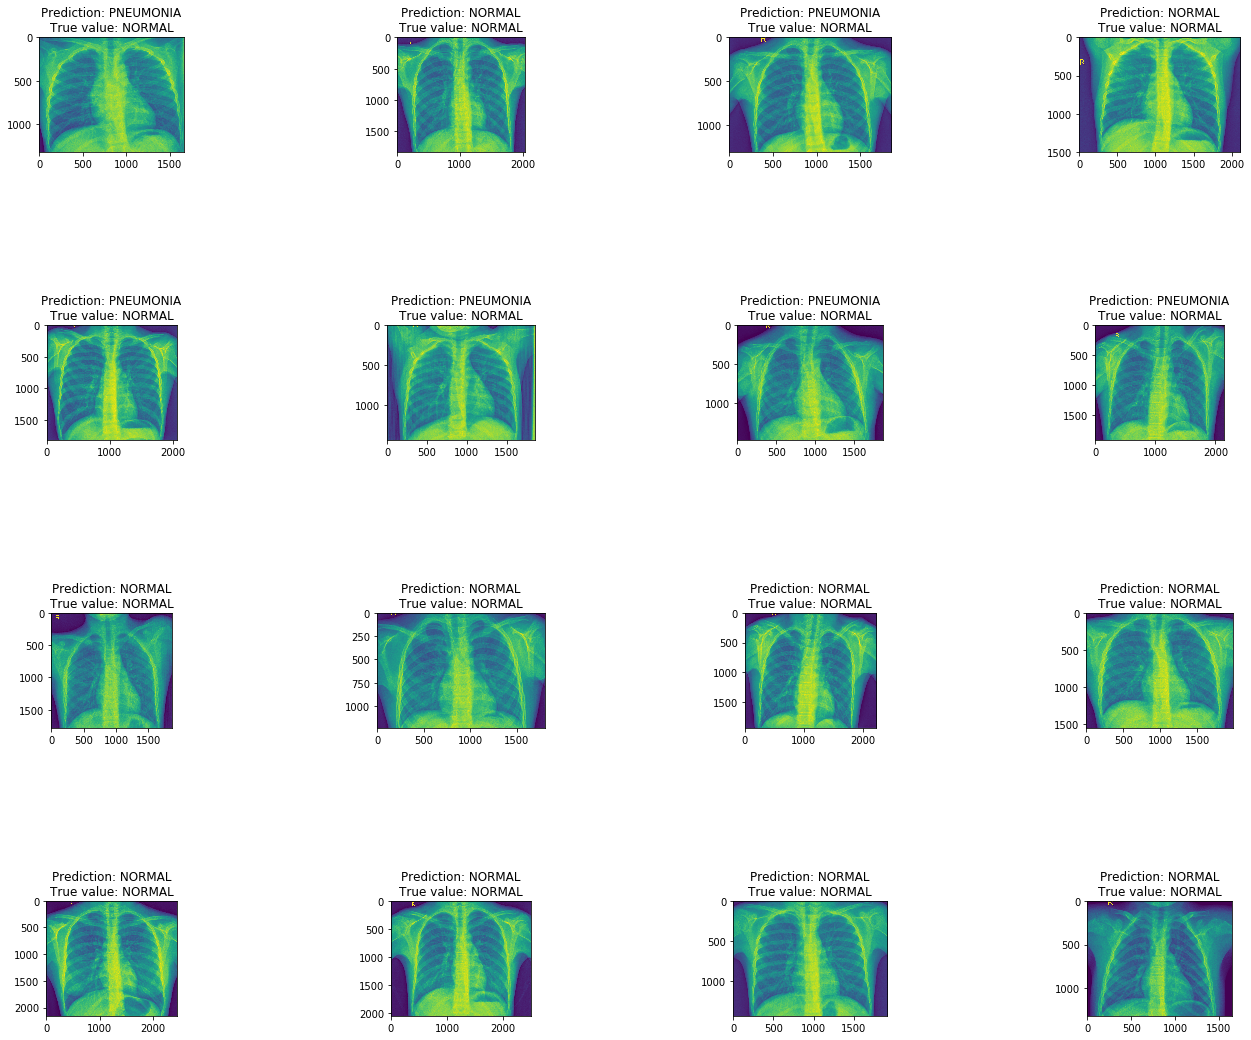

In [133]:
compare_results(test_dir, validation_generator)